In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
!wget  'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

--2024-07-09 20:19:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   197MB/s    in 0.3s    

2024-07-09 20:19:52 (197 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('cats_and_dogs_filtered.zip','r')
zip_ref.extractall('cats_and_dogs')
zip_ref.close()

In [ ]:
os.listdir('cats_and_dogs/cats_and_dogs_filtered')

['train', 'validation', 'vectorize.py']

In [ ]:
os.listdir('cats_and_dogs/cats_and_dogs_filtered/train')

['cats', 'dogs']

In [ ]:
print(len(os.listdir('cats_and_dogs/cats_and_dogs_filtered/train/cats')))

1000


In [ ]:
train_dir='cats_and_dogs/cats_and_dogs_filtered/train'
test_dir='cats_and_dogs/cats_and_dogs_filtered/validation'

In [ ]:
BATCH_SIZE=32
IMG_SIZE=(160,160)
train_data=tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       shuffle=True,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_data=tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      shuffle=True,
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


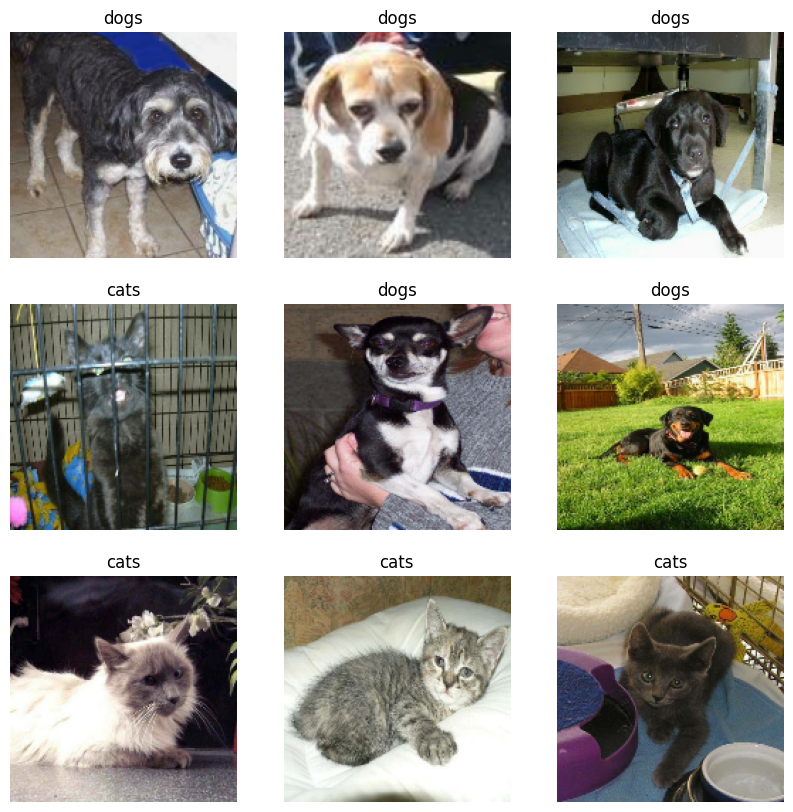

In [ ]:
class_names=train_data.class_names
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
val_batches=tf.data.experimental.cardinality(validation_data)
test_data=validation_data.take(val_batches//5)
validation_data=validation_data.skip(val_batches//5)

In [ ]:
print('Number of validation bathces: %d' %tf.data.experimental.cardinality(validation_data))
print('Number of test bathces: %d' % tf.data.experimental.cardinality(test_data))

Number of validation bathces: 26
Number of test bathces: 6


In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
train_data=train_data.prefetch(buffer_size=AUTOTUNE)
validation_data=validation_data.prefetch(buffer_size=AUTOTUNE)
test_data=test_data.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

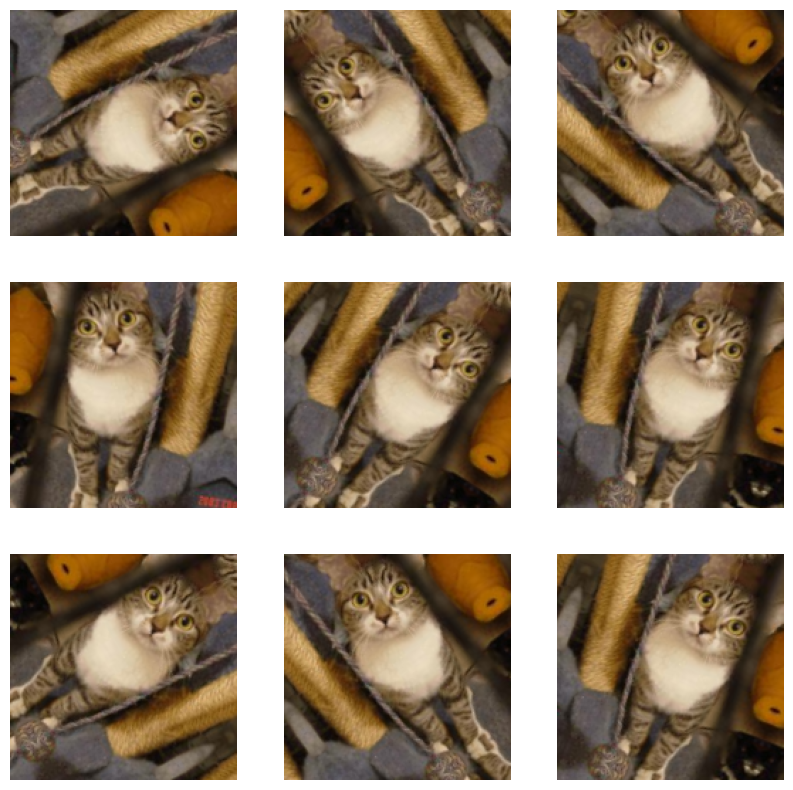

In [ ]:
for image, _ in train_data.take(1):
  plt.figure(figsize=(10,10))
  first_image=image[0]
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    augmented_image=data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

In [ ]:
preprocess_input=tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# create teh base model from the pretrained model MobileNet V2
IMG_SHAPE=IMG_SIZE + (3,)
base_model=tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch=next(iter(train_data))
feature_batch=base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable=False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average=global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer=tf.keras.layers.Dense(1,activation='sigmoid')
prediction_batch=prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs=tf.keras.Input(shape=(160,160,3))
x=data_augmentation(inputs)
x=preprocess_input(x)
x=base_model(x, training=False)
x=global_average_layer(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=prediction_layer(x)
model=tf.keras.Model(inputs, outputs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
len(model.trainable_variables)

2

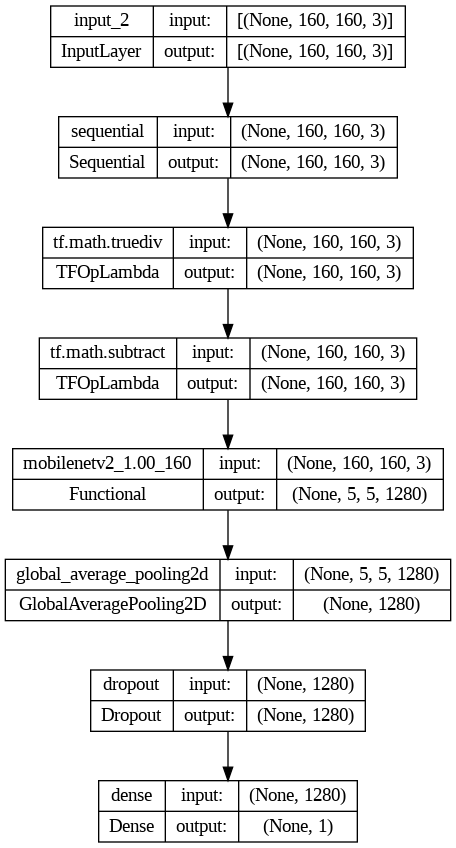

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
base_learning_rate=0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
              )

In [ ]:
initial_epochs=10
loss0, accuracy0=model.evaluate(validation_data)

26/26 [==============================] - 5s 77ms/step - loss: 0.7257 - accuracy: 0.5384


In [ ]:
print('initial loss: {:.2f}'.format(loss0))
print('initial accurcy: {:.2f}'.format(accuracy0))

initial loss: 0.73
initial accurcy: 0.54


In [ ]:
history=model.fit(train_data,
                  epochs=initial_epochs,
                  validation_data=validation_data)

Epoch 1/10
63/63 [==============================] - 64s 954ms/step - loss: 0.7551 - accuracy: 0.5470 - val_loss: 0.5805 - val_accuracy: 0.6968
Epoch 2/10
63/63 [==============================] - 61s 974ms/step - loss: 0.5611 - accuracy: 0.7060 - val_loss: 0.4186 - val_accuracy: 0.8354
Epoch 3/10
63/63 [==============================] - 57s 906ms/step - loss: 0.4559 - accuracy: 0.7900 - val_loss: 0.3323 - val_accuracy: 0.9035
Epoch 4/10
63/63 [==============================] - 61s 962ms/step - loss: 0.3891 - accuracy: 0.8445 - val_loss: 0.2679 - val_accuracy: 0.9319
Epoch 5/10
63/63 [==============================] - 55s 873ms/step - loss: 0.3287 - accuracy: 0.8735 - val_loss: 0.2263 - val_accuracy: 0.9468
Epoch 6/10
63/63 [==============================] - 54s 858ms/step - loss: 0.2865 - accuracy: 0.8970 - val_loss: 0.1990 - val_accuracy: 0.9542
Epoch 7/10
63/63 [==============================] - 60s 956ms/step - loss: 0.2624 - accuracy: 0.9000 - val_loss: 0.1724 - val_accuracy: 0.9641

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel("accuracy")
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.ylabel('cross entropy')
plt.ylim([0,1.0])
plt.xlabel('epoch')
plt.title('Training and Validation Loss')
plt.show()